In [273]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import data_preprocessing as dp
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

Temp to Spec
Loss: 0.0233

# Prepare Data

In [274]:
X, y = dp.get_data(file_path='combined_data.xlsx', direction=1, noise_scale=0.0001, spec_scale=10**13)

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [276]:
loader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=32)

# Design Model 
(input size, output size, forward pass)

In [277]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 16)
        self.lin2 = nn.Linear(16, 32)
        self.lin3 = nn.Linear(32, 64)
        self.lin_fin = nn.Linear(64, output_size)


    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [278]:
n_samples, input_size = X_train.shape
_, output_size = y_train.shape

model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [279]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

# Training Loop

In [280]:
num_epochs = 3000

for epoch in range(num_epochs):
    for X_batch, y_batch in loader:
        # forward pass and loss
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

epoch: 300, loss = 58.4490
epoch: 600, loss = 53.8160
epoch: 900, loss = 50.2721
epoch: 1200, loss = 48.5552
epoch: 1500, loss = 37.5582
epoch: 1800, loss = 48.6165
epoch: 2100, loss = 120.9587
epoch: 2400, loss = 76.7784
epoch: 2700, loss = 61.0472
epoch: 3000, loss = 186.5793


# Plots

In [281]:
pred = model(X_test)
pred = pd.DataFrame(pred.detach().numpy())

actual = pd.DataFrame(y_test.detach().numpy())

In [282]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(index):
    actual_np = actual.values[index]
    pred_np = pred.values[index]


    plt.plot(actual.columns, actual_np, label='actual')
    plt.plot(actual.columns, pred_np, 'r+', label='predicted')

    if 0:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

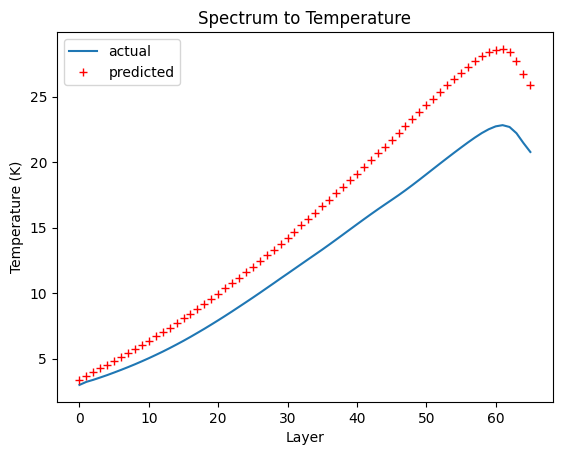

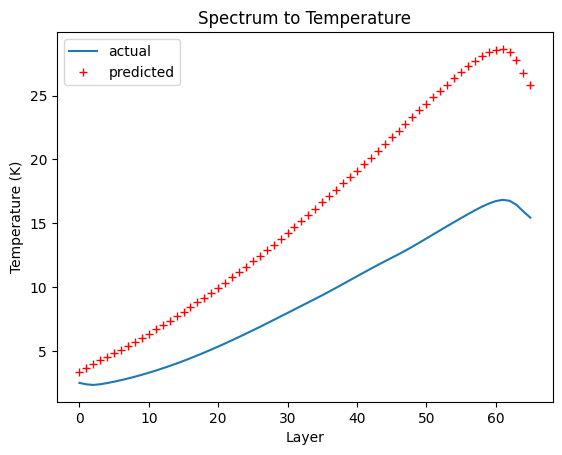

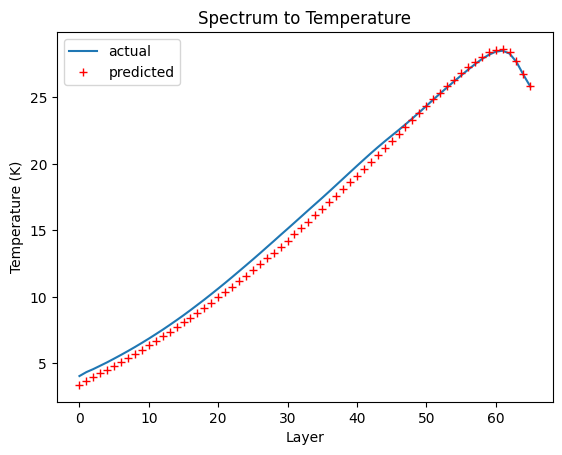

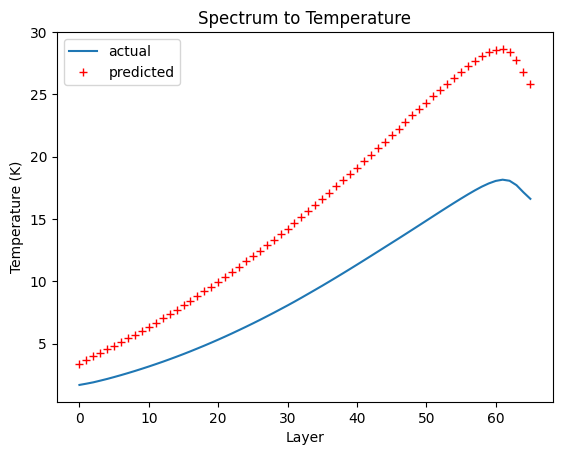

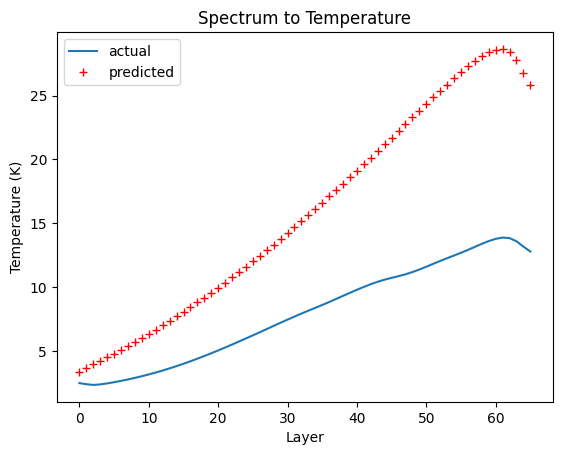

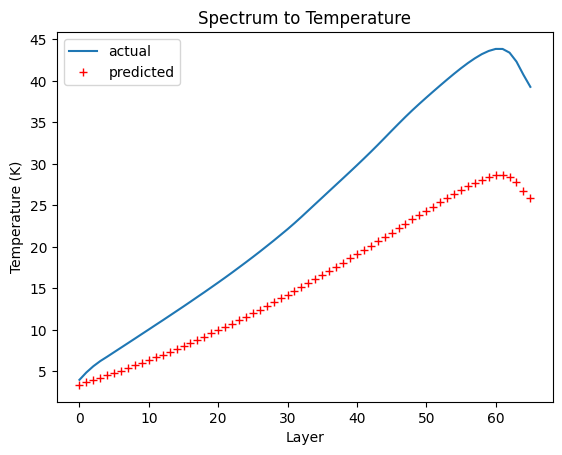

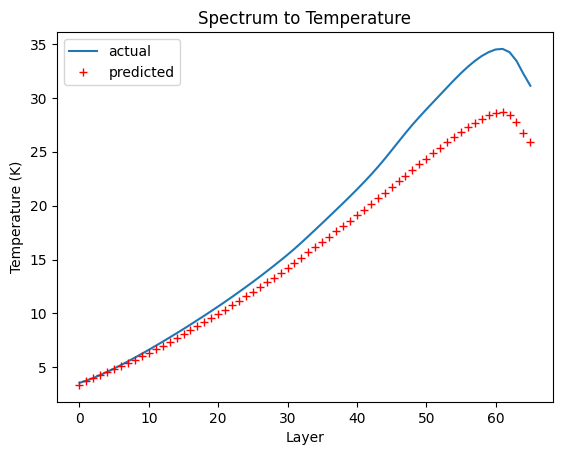

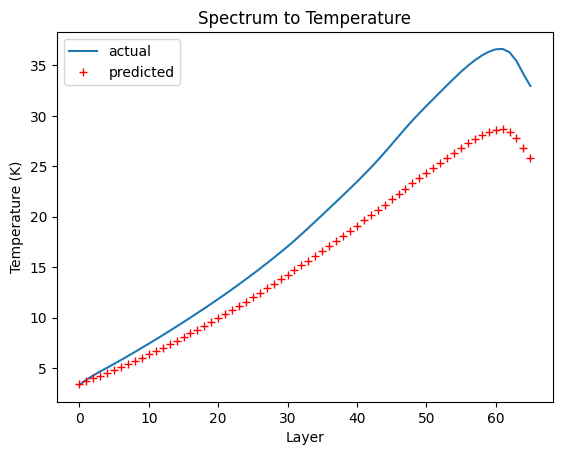

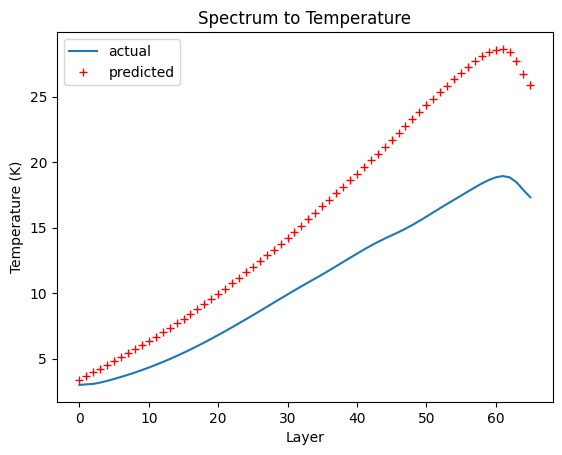

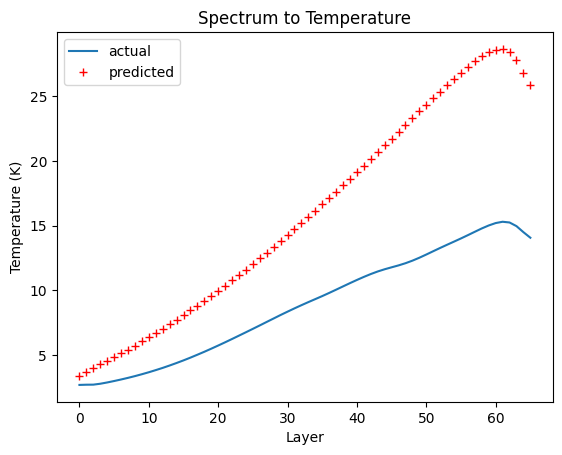

In [283]:
for index in range(10):
    plot_actual_vs_pred(index*10)